In [115]:
import cv2
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from shapely import wkb, geometry
from mrcnn import model as modellib
from mrcnn.visualize import display_instances
from mrcnn.config import Config

In [116]:
from tanzania_challenge import buildings

In [118]:
from importlib import reload
reload(buildings)
reload(modellib)

<module 'mrcnn.model' from '/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py'>

## Load configuration

In [198]:
class BuildingsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "buildings"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BuildingsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [307]:
DATAPATH = os.path.join("..", "data", "open_ai_tanzania", "preprocessed")
dataset = "training"

In [254]:
def gen_path(datapath, img_size, dataset, info, filename):
    return os.path.join(datapath, str(img_size), dataset, info, filename)

## Load images

In [325]:
instance = np.random.choice(os.listdir(os.path.join(DATAPATH, str(config.IMAGE_MIN_DIM), dataset, "images"))).split(".")[0]

In [326]:
im = Image.open(gen_path(DATAPATH, str(config.IMAGE_MIN_DIM), dataset ,"images", instance + ".tif"))

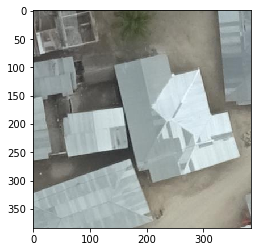

In [327]:
plt.imshow(im)

In [328]:
with open(gen_path(DATAPATH, str(config.IMAGE_MIN_DIM), dataset, "items", instance + ".json")) as fobj:
    labels = json.load(fobj)

In [329]:
labels

{'0': {'condition': 'Complete',
  'geom': '0103000020E17F0000010000000500000000004721904120418860D119B0DD61411AF4E2AF894120410068B625B0DD61411B718F5C874120410084B2B5B1DD614100004721904120410084B2B5B1DD614100004721904120418860D119B0DD6141'},
 '1': {'condition': 'Complete',
  'geom': '0103000020E17F0000010000000600000000C016A05441204145DD3392AEDD6141AB9DB5BC6E41204157D3A029AFDD61411CF30A5A7541204163E4B11AAEDD614180743F317041204100809FFDADDD614100C016A05441204100809FFDADDD614100C016A05441204145DD3392AEDD6141'},
 '2': {'condition': 'Complete',
  'geom': '0103000020E17F0000010000000B0000007D7B93E66A412041C33907C0B0DD6141D39DB5A8784120412AA02DF9B0DD6141985971E87A4120416DE4B195B0DD614184263E0D82412041900654B3B0DD614180152D18854120417BF502E6AFDD6141F16A82B9894120418C06D4F4AFDD6141A2152D088D41204167E47138AFDD61413F152D387541204143C28FBBAEDD614152263E297441204144C20FFBAEDD6141EBD0E88371412041CC4A98F2AEDD61417D7B93E66A412041C33907C0B0DD6141'},
 '3': {'condition': 'Incomplete',
  'geom': '01030000

## Build the dataset

In [331]:
bd = buildings.BuildingDataset()

In [332]:
bd.load_buildings(DATAPATH, subset=dataset, img_size=config.IMAGE_MIN_DIM)

In [333]:
bd.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'building', 'id': 1, 'name': 'complete'},
 {'source': 'building', 'id': 2, 'name': 'unfinished'},
 {'source': 'building', 'id': 3, 'name': 'foundation'}]

In [334]:
len(bd.image_info)

2786

In [335]:
bd.image_info[0]

{'id': 0,
 'source': 'building',
 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_26880_6912.tif',
 'name': 'grid_001_384_384_26880_6912.tif',
 'raw_image_path': '../data/input/images/grid_001.tif',
 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_26880_6912.json',
 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_26880_6912.json',
 'width': 384,
 'height': 384}

In [336]:
bd.prepare()

## Wrong geom tracking

In [421]:
i = int(np.random.sample() * len(bd.image_info))

In [422]:
bd.load_mask(i)

(array([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        ...,
 
        [[0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=int8), array([3, 3, 3, 2], dtype=uint8))

In [423]:
bd.image_info[i]

{'id': 2706,
 'source': 'building',
 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_18816_28032.tif',
 'name': 'grid_001_384_384_18816_28032.tif',
 'raw_image_path': '../data/input/images/grid_001.tif',
 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_18816_28032.json',
 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_18816_28032.json',
 'width': 384,
 'height': 384}

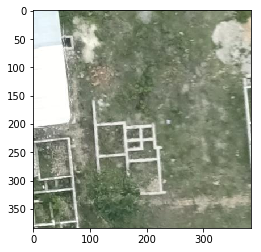

In [424]:
im = Image.open(bd.image_info[i]["path"])
plt.imshow(im)

In [425]:
with open(bd.image_info[i]["item_path"]) as fobj:
    labels = json.load(fobj)
labels

{'0': {'condition': 'Foundation',
  'geom': '0103000020E17F0000010000000400000000806C3BAD4620414A0CCF0A13DD6141A762A91CAB46204188771E6114DD614100806C3BAD4620418CCB246514DD614100806C3BAD4620414A0CCF0A13DD6141'},
 '1': {'condition': 'Foundation',
  'geom': '0103000020E17F00000100000009000000B52E76A1824620412F22199013DD614194EA31D58A462041C9BB729613DD6141BA0C54B38A462041D9CC838513DD6141072F7681924620417366DD8B13DD6141E30C54A39246204171669D2C13DD61412C51985B9446204193887F2A13DD614189A6ED0495462041D4CCC36712DD61416AD920F483462041B1AA214A12DD6141B52E76A1824620412F22199013DD6141'},
 '2': {'condition': 'Foundation',
  'geom': '0103000020E17F0000010000000500000000403CBA7146204147E8204313DD61415EFB42637B4620410C00B75213DD614104F435FE7D46204100D880CA11DD614100403CBA7146204100D880CA11DD614100403CBA7146204147E8204313DD6141'},
 '3': {'condition': 'Incomplete',
  'geom': '0103000020E17F00000100000005000000C5B400E67746204100DC938215DD61411CB7FEA67B462041EBDD449C13DD614100403CBA714620410382CD8113DD6141

In [426]:
with open(bd.image_info[i]["feature_path"]) as fobj:
    features = json.load(fobj)
features

{'west': 533304.863740921,
 'south': 9365646.328227997,
 'east': 533334.6160621643,
 'north': 9365676.08054924,
 'srid': 32737,
 'width': 384,
 'height': 384}

## Display images and masks

In [427]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(bd, config, i, use_mini_mask=False)

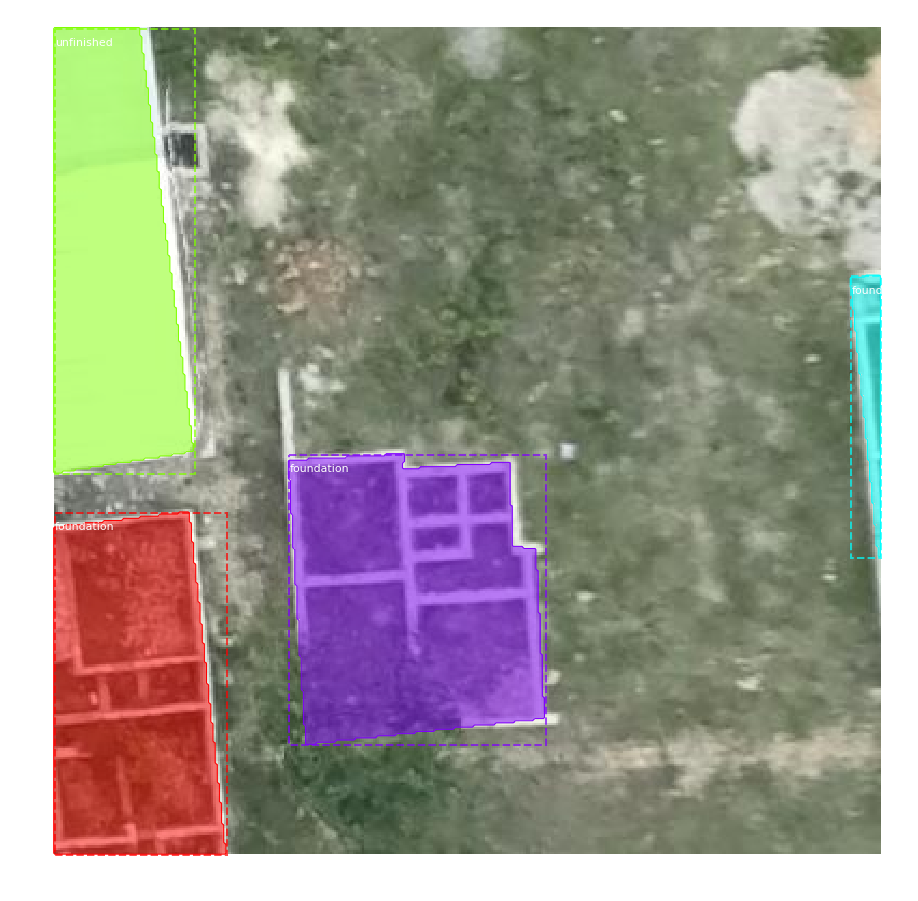

In [428]:
display_instances(image, gt_bbox, gt_mask, gt_class_id, bd.class_names,
                            show_bbox=True)